# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from matplotlib import pyplot as plt

# **Preprocessing MNIST dataset**

***Load and Preprocess the Data***

We load the **MNIST handwritten digit dataset**, which contains grayscale images of size `28×28`.

- Flatten each image into a `784`-dimensional vector
- Normalize pixel values to range `[0, 1]` for better training


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1,28*28)/255.0
X_test = X_test.reshape(-1,28*28)/255.0
(X_train.shape,X_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 784), (10000, 784))

***One-Hot Encode the Labels***

We convert the target labels (digits 0–9) into **one-hot encoded vectors** so they can be used with our output layer (which has 10 neurons).

- Turns a digit like `5` into: `[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]`
- Required for computing loss during training



In [3]:
y_train_oh = np.zeros((y_train.shape[0], 10))
y_train_oh[np.arange(y_train.shape[0]), y_train] = 1
y_test_oh = np.zeros((y_test.shape[0], 10))
y_test_oh[np.arange(y_test.shape[0]), y_test] = 1
(y_train_oh.shape,y_test_oh.shape)

((60000, 10), (10000, 10))

# **Initializing Weights**

***Initialize Network Weights***

We define the architecture and initialize weights for our 2-layer neural network.

- `input_size = 784` (flattened 28×28 image)
- `hidden_size = 128` (number of neurons in the hidden layer)
- `output_size = 10` (one for each digit class)

Weights (`W1`, `W2`) are initialized with small random values (scaled using He/Glorot initialization), and biases (`b1`, `b2`) are initialized to zeros.


In [4]:
input_size=784
hidden_size=128
output_size=10

In [5]:
def init_weights(input_size, hidden_size, output_size):
  W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
  b1 = np.zeros((1, hidden_size))
  W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
  b2 = np.zeros((1, output_size))
  return W1,b1,W2,b2

In [6]:
init_weights(input_size, hidden_size, output_size)

(array([[-0.01723778, -0.01987831,  0.02531838, ...,  0.02242676,
         -0.05218422, -0.03326778],
        [-0.03700042, -0.00557473,  0.0216599 , ..., -0.09449718,
          0.01020194, -0.00319248],
        [ 0.0578491 ,  0.00104854, -0.01595838, ..., -0.01803981,
         -0.03717852,  0.02247565],
        ...,
        [ 0.00764144, -0.0001393 ,  0.01788232, ...,  0.01222665,
          0.03816425, -0.04537624],
        [ 0.00638423, -0.03234512,  0.0022337 , ..., -0.00996929,
         -0.03958532, -0.01561484],
        [-0.01063959,  0.03035648, -0.04745029, ..., -0.05524843,
          0.01853308,  0.09025922]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

# **Defining Activation Functions**

***Activation Functions***

We define the activation functions used in our network:

- **ReLU (Rectified Linear Unit)**: Applies `max(0, x)` to add non-linearity and avoid vanishing gradients.
- **ReLU Derivative**: Used during backpropagation to compute gradients.
- **Softmax**: Converts raw output scores into a probability distribution over 10 classes (used in the output layer).


In [7]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(shifted_x)
    sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
    return exp_x / sum_exp_x

# **Defining Forward and Backward Passes**

***Forward Propagation***

This function computes the forward pass through the network:

- `Z1 = X · W1 + b1`: Linear transformation from input to hidden layer
- `A1 = ReLU(Z1)`: Apply non-linearity
- `Z2 = A1 · W2 + b2`: Linear transformation from hidden to output
- `A2 = Softmax(Z2)`: Converts raw scores to class probabilities

Returns intermediate outputs needed for backpropagation.


In [8]:
def forward(W1, b1, W2, b2, X):
  Z1 = np.dot(X, W1) + b1
  A1 = relu(Z1)
  Z2 = np.dot(A1, W2) + b2
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

***Backpropagation***

This function computes gradients of the loss with respect to all weights and biases:

- `dZ2 = A2 - y`: Error at output layer (from Softmax + Cross-Entropy)
- `dW2`, `db2`: Gradients for output layer weights and biases
- `dZ1`: Propagated error to hidden layer, scaled by ReLU derivative
- `dW1`, `db1`: Gradients for hidden layer weights and biases

These gradients are used to update the parameters during training.


In [9]:
def backward(A1, W1, Z1, A2, W2, Z2, X, y):
  m = X.shape[0]
  dZ2 = A2 - y
  dW2 = np.dot(A1.T, dZ2) / m
  db2 = np.sum(dZ2, axis=0, keepdims=True) / m
  dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1)
  dW1 = np.dot(X.T, dZ1) / m
  db1 = np.sum(dZ1, axis=0, keepdims=True) / m
  return dW1, db1, dW2, db2

***Update Weights (Gradient Descent)***

We update the weights and biases using **gradient descent**:

- Subtract a small fraction (`learning_rate`) of the gradient from each parameter
- This helps the model minimize the loss in the next iteration

Formula:  
`parameter = parameter - learning_rate × gradient`


In [10]:
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
  W1 -= lr * dW1
  b1 -= lr * db1
  W2 -= lr * dW2
  b2 -= lr * db2
  return W1, b1, W2, b2

# **Defining Accuracy Functions**

***Predictions and Accuracy***

- `get_predictions(A2)`: Returns the index of the highest probability for each sample (i.e., predicted class)
- `accuracy(predictions, y)`: Compares predictions with true labels and computes the overall accuracy


In [11]:
def get_predictions(A2):
  return np.argmax(A2, axis=1)

def accuracy(predictions, y):
  return np.mean(predictions == np.argmax(y, axis=1))

# **Train Our Network**

***Training Loop***

This function trains the neural network over multiple epochs:

- Performs **forward pass**, **backpropagation**, and **weight updates**
- Prints accuracy every 10 epochs to monitor progress
- Returns the final trained weights and biases

Arguments:
- `X`: input data  
- `y`: one-hot encoded labels  
- `epochs`: number of training cycles  
- `lr`: learning rate for gradient descent


In [12]:
def train(X, y, epochs, lr):
  W1, b1, W2, b2 = init_weights(input_size, hidden_size, output_size)
  for epoch in range(epochs):

    Z1, A1, Z2, A2 = forward(W1, b1, W2, b2, X)
    dW1, db1, dW2, db2 = backward(A1, W1, Z1, A2, W2, Z2, X, y)
    W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
    if epoch%10==0:
      print("Epoch: ",epoch)
      print("Accuracy: ",accuracy(get_predictions(A2), y))
  return W1, b1, W2, b2

In [13]:
W1, b1, W2, b2 = train(X_train, y_train_oh, 500, 0.01)

Epoch:  0
Accuracy:  0.0906
Epoch:  10
Accuracy:  0.1603
Epoch:  20
Accuracy:  0.25738333333333335
Epoch:  30
Accuracy:  0.33535
Epoch:  40
Accuracy:  0.3874666666666667
Epoch:  50
Accuracy:  0.4320833333333333
Epoch:  60
Accuracy:  0.47613333333333335
Epoch:  70
Accuracy:  0.51555
Epoch:  80
Accuracy:  0.5535166666666667
Epoch:  90
Accuracy:  0.5867666666666667
Epoch:  100
Accuracy:  0.61385
Epoch:  110
Accuracy:  0.6367666666666667
Epoch:  120
Accuracy:  0.6551166666666667
Epoch:  130
Accuracy:  0.66945
Epoch:  140
Accuracy:  0.6815833333333333
Epoch:  150
Accuracy:  0.6921166666666667
Epoch:  160
Accuracy:  0.7019
Epoch:  170
Accuracy:  0.71105
Epoch:  180
Accuracy:  0.7194833333333334
Epoch:  190
Accuracy:  0.72775
Epoch:  200
Accuracy:  0.7346833333333334
Epoch:  210
Accuracy:  0.7417333333333334
Epoch:  220
Accuracy:  0.7481666666666666
Epoch:  230
Accuracy:  0.7543333333333333
Epoch:  240
Accuracy:  0.7599166666666667
Epoch:  250
Accuracy:  0.7655333333333333
Epoch:  260
Accurac

# **Test Our Network**

***Make Predictions***

This function uses the trained weights to make predictions on new input data:

- Performs a **forward pass** to compute output probabilities
- Uses `get_predictions()` to select the class with the highest probability

Returns predicted class labels for each input sample.


In [14]:
def make_predictions(X, W1, b1, W2, b2):
  _, _, _, A2 = forward(W1, b1, W2, b2, X)
  predictions = get_predictions(A2)
  return predictions


In [15]:
test_predictions = make_predictions(X_test, W1, b1, W2, b2)
print("Test accuracy: ",accuracy(test_predictions, y_test_oh))

Test accuracy:  0.8466


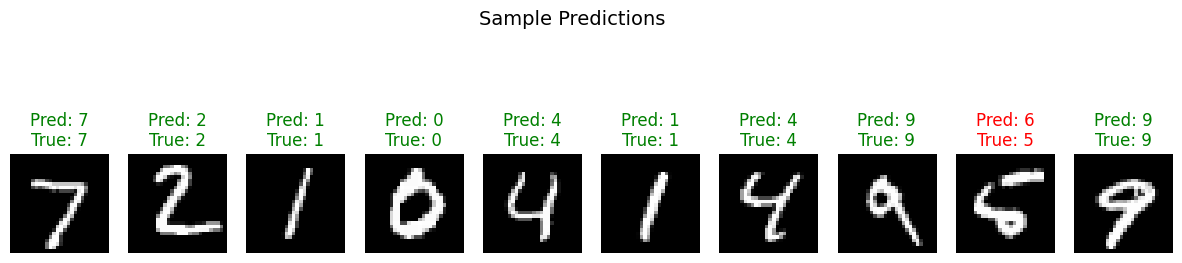

In [16]:
def show_sample_predictions(X, y_true, y_pred, count=10):
    plt.figure(figsize=(15, 4))
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {y_pred[i]}\nTrue: {y_true[i]}",
                  color='green' if y_pred[i] == y_true[i] else 'red')
        plt.axis('off')
    plt.suptitle("Sample Predictions", fontsize=14)
    plt.show()

preds = make_predictions(X_test, W1, b1, W2, b2)
show_sample_predictions(X_test, y_test, preds)
